## Import tools

In [1]:
import numpy as np
import pandas as pd
import time

## Get the data

In [2]:
data = pd.read_csv(r"C:\Users\91831\Desktop\Internship\airfoil_noise_data.csv")
data.head(5)

,x0,x1,x2,x3,x4,y
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [3]:
data.shape

(1503, 6)

#  Prototype-1

## Node class

In [4]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):

        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        self.value = value

## Tree class

In [5]:
class DecisionTreeRegressor_1():
    def __init__(self, min_samples_split=2, max_depth=2):

        self.root = None
        self.level_l=0
        self.level_r=0
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}

        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:

            best_split = self.get_best_split(dataset, num_samples, num_features)

            if best_split["var_red"]>0:

                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)

                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)

                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        

        leaf_value = self.calculate_leaf_value(Y)

        return Node(value=leaf_value)
    
    def split(self, dataset, feature_index, threshold):
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        
        val = np.mean(Y)
        return val                

    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_var_red = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            print(possible_thresholds)
            for threshold in possible_thresholds:
                
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    curr_var_red = self.variance_reduction(y, left_y, right_y)

                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        return best_split
    
    def print_tree(self, tree=None,indent="--"):
        
        if not tree:
            print("Root Node")
            tree = self.root
    
        if tree.value is not None:
            print(tree.value)
            print(end="\n")

        else:
            temp=0
            print("X_"+str(tree.feature_index), "== tree_threshold ->", tree.threshold, ", var_red->", tree.var_red)
            print(end="\n")
            if indent=="--":
                self.level_l=+1
                print("|->  level",self.level_l,"%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                self.level_r=+1
                print("|-> level",self.level_r,"%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
                
            elif indent=="----":
                self.level_l=temp+2
                print("     |--->>  level",self.level_l,"%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                self.level_r=temp+2
                print("     |--->>  level",self.level_r,"%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
                
            elif indent=="--------":
                self.level_l=temp+3
                print("        |------->>>>>>>  level",self.level_l,"%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                self.level_r=temp+3
                print("        |------->>>>>>>  level",self.level_r,"%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
                
            else:
                self.level_l=temp+4
                self.level_r=temp+4
                print("                |----leaf Node------>>>  level",self.level_l,"%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("                |----leaf node------>>>  level",self.level_r,"%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else: 
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions


## Train-Test split

In [6]:
#X = data.iloc[:, :-1].values
#Y = data.iloc[:, -1].values.reshape(-1,1)
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [7]:
X_train_=data.iloc[:1203, :-1].values
X_test_=data.iloc[1203:, :-1].values
Y_train_=data.iloc[:1203, -1].values.reshape(-1,1)
Y_test_=data.iloc[1203:, -1].values.reshape(-1,1)
X_train_

array([[8.00000e+02, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
       [1.00000e+03, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
       [1.25000e+03, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
       ...,
       [6.30000e+02, 1.74000e+01, 2.54000e-02, 3.17000e+01, 1.76631e-02],
       [8.00000e+02, 1.74000e+01, 2.54000e-02, 3.17000e+01, 1.76631e-02],
       [1.00000e+03, 1.74000e+01, 2.54000e-02, 3.17000e+01, 1.76631e-02]])

In [8]:
st = time.time()

## Fit the model

In [9]:
regressor = DecisionTreeRegressor_1(min_samples_split=3, max_depth=3)
regressor.fit(X_train_,Y_train_)

[  200.   250.   315.   400.   500.   630.   800.  1000.  1250.  1600.
  2000.  2500.  3150.  4000.  5000.  6300.  8000. 10000. 12500. 16000.
 20000.]
[ 0.   1.5  2.   2.7  3.   4.   4.2  4.8  5.3  5.4  7.2  7.3  8.4  9.5
  9.9 11.2 12.6 12.7 15.4 17.4 19.7]
[0.0254 0.0508 0.1524 0.2286 0.3048]
[31.7 39.6 55.5 71.3]
[0.00040068 0.00041229 0.00042846 0.00043947 0.00074048 0.00076193
 0.00079182 0.00081216 0.00084863 0.00087322 0.00090748 0.00093079
 0.00142788 0.00152689 0.0015988  0.00172668 0.00193287 0.00209405
 0.00214345 0.00229336 0.00243851 0.00253511 0.00266337 0.0027238
 0.00283081 0.00293031 0.00294804 0.00310138 0.00313525 0.00331266
 0.00336729 0.00346574 0.00372371 0.00392107 0.00400603 0.00401199
 0.00420654 0.00425727 0.0042862  0.0043284  0.00433288 0.00449821
 0.00452492 0.00461377 0.00473801 0.00485029 0.00495741 0.00497773
 0.00509068 0.0051942  0.00525474 0.00529514 0.00544854 0.00566229
 0.00579636 0.00580776 0.00614329 0.00752039 0.00909175 0.0104404
 0.0111706  0.

## Test the model Prototype-1

In [10]:
Y_pred_1= regressor.predict(X_test_) 

#from sklearn.metrics import mean_squared_error

#mse=mean_squared_error(Y_test_, Y_pred)
#mse

In [11]:
#rmse=np.sqrt(mean_squared_error(Y_test_, Y_pred))
#rmse

In [12]:
Y_test_=Y_test_.tolist()
flatten_list = [j for sub in Y_test_ for j in sub]
flatten_list

[128.306,
 126.846,
 124.356,
 124.166,
 123.466,
 121.996,
 117.996,
 115.857,
 117.927,
 117.967,
 120.657,
 123.227,
 134.247,
 140.987,
 131.817,
 127.197,
 126.097,
 124.127,
 123.917,
 125.727,
 123.127,
 121.657,
 116.066,
 117.386,
 120.716,
 123.416,
 129.776,
 137.026,
 137.076,
 128.416,
 126.446,
 122.216,
 121.256,
 121.306,
 120.856,
 119.646,
 118.816,
 124.155,
 126.805,
 128.825,
 130.335,
 131.725,
 132.095,
 132.595,
 131.955,
 130.935,
 130.795,
 129.395,
 125.465,
 123.305,
 119.375,
 126.17,
 127.92,
 129.8,
 131.43,
 132.05,
 132.54,
 133.04,
 131.78,
 129.5,
 128.36,
 127.73,
 124.45,
 121.93,
 119.91,
 125.401,
 128.401,
 130.781,
 132.271,
 133.261,
 133.251,
 132.611,
 130.961,
 127.801,
 126.021,
 125.631,
 122.341,
 119.561,
 126.413,
 129.053,
 131.313,
 133.063,
 133.553,
 133.153,
 132.003,
 129.973,
 126.933,
 124.393,
 124.253,
 120.193,
 115.893,
 131.074,
 131.434,
 132.304,
 133.664,
 134.034,
 133.894,
 132.114,
 128.704,
 127.054,
 124.904,
 121.2

In [13]:
len(flatten_list)

300

In [14]:
Y_pred_1

[125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 126.32877777777779,
 126.32877777777779,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 121.91676923076923,
 126.32877777777779,
 126.32877777777779,
 120.22430769230769,
 120.22430769230769,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 125.82253445065177,
 126.32877777777779,
 126.32877777777779,
 129.11080597014927,
 129.11080597014927,
 129.11080597014927,
 129.11080597014927,
 129.11080597014927,
 129.11080597014927,
 129.11080597014927,
 129.11080597014927,
 130.50583333333333,
 130.50583333333333,
 130.50583333

In [15]:
len(Y_pred_1)

300

In [16]:
sub=np.subtract(flatten_list,Y_pred_1)
sub

array([ 2.48346555e+00,  1.02346555e+00, -1.46653445e+00, -1.65653445e+00,
       -2.35653445e+00, -4.33277778e+00, -8.33277778e+00, -6.05976923e+00,
       -3.98976923e+00, -3.94976923e+00, -1.25976923e+00,  1.31023077e+00,
        1.23302308e+01,  1.90702308e+01,  9.90023077e+00,  5.28023077e+00,
        4.18023077e+00,  2.21023077e+00, -2.41177778e+00, -6.01777778e-01,
        2.90269231e+00,  1.43269231e+00, -9.75653445e+00, -8.43653445e+00,
       -5.10653445e+00, -2.40653445e+00,  3.95346555e+00,  1.12034655e+01,
        1.12534655e+01,  2.59346555e+00,  6.23465549e-01, -3.60653445e+00,
       -4.56653445e+00, -4.51653445e+00, -4.96653445e+00, -6.68277778e+00,
       -7.51277778e+00, -4.95580597e+00, -2.30580597e+00, -2.85805970e-01,
        1.22419403e+00,  2.61419403e+00,  2.98419403e+00,  3.48419403e+00,
        2.84419403e+00,  4.29166667e-01,  2.89166667e-01, -1.11083333e+00,
        7.71166667e-01, -1.38883333e+00, -5.31883333e+00,  3.47465549e-01,
        2.09746555e+00,  

In [17]:
sqre=np.square(sub)
sqre

array([6.16760113e+00, 1.04748173e+00, 2.15072329e+00, 2.74410639e+00,
       5.55325462e+00, 1.87729633e+01, 6.94351855e+01, 3.67208031e+01,
       1.59182585e+01, 1.56006770e+01, 1.58701851e+00, 1.71670467e+00,
       1.52034591e+02, 3.63673702e+02, 9.80145693e+01, 2.78808370e+01,
       1.74743293e+01, 4.88512005e+00, 5.81667205e+00, 3.62136494e-01,
       8.42562263e+00, 2.05260725e+00, 9.51899645e+01, 7.11751135e+01,
       2.60766941e+01, 5.79140806e+00, 1.56298898e+01, 1.25517640e+02,
       1.26640487e+02, 6.72606356e+00, 3.88709291e-01, 1.30070907e+01,
       2.08532369e+01, 2.03990834e+01, 2.46664644e+01, 4.46595188e+01,
       5.64418299e+01, 2.45600128e+01, 5.31674117e+00, 8.16850526e-02,
       1.49865102e+00, 6.83401043e+00, 8.90541401e+00, 1.21396080e+01,
       8.08943968e+00, 1.84184028e-01, 8.36173611e-02, 1.23395069e+00,
       5.94698028e-01, 1.92885803e+00, 2.82899880e+01, 1.20732308e-01,
       4.39936173e+00, 1.58202322e+01, 3.14436699e+01, 3.87813272e+01,
      

In [18]:
s=sqre.sum()
s

9834.572351494919

In [19]:
Mean_Square_Error=s/301
Mean_Square_Error

32.67299784549807

In [20]:
import math 
RMSE = math.sqrt(Mean_Square_Error) 
RMSE

5.716029902432113

In [21]:
et = time.time()
elapsed_time_1 = et - st
print('Execution time:', elapsed_time_1, 'seconds')

Execution time: 0.7551429271697998 seconds


# Printing Tree of Prototype_1

In [22]:
regressor.print_tree()

Root Node
X_0 == tree_threshold -> 3150.0 , var_red-> 6.760936955515788

|->  level 1 --left:X_4 == tree_threshold -> 0.0282593 , var_red-> 3.028836043632122

     |--->>  level 2 ----left:X_3 == tree_threshold -> 55.5 , var_red-> 1.3328017704725745

        |------->>>>>>>  level 3 --------left:X_4 == tree_threshold -> 0.000812164 , var_red-> 1.0570197515650577

                |----leaf Node------>>>  level 4 ----------------left:130.16714705882353

                |----leaf node------>>>  level 4 ----------------right:125.82253445065177

        |------->>>>>>>  level 3 --------right:X_1 == tree_threshold -> 15.4 , var_red-> 2.952957291456176

                |----leaf Node------>>>  level 4 ----------------left:129.11080597014927

                |----leaf node------>>>  level 4 ----------------right:121.91676923076923

     |--->>  level 2 ----right:X_4 == tree_threshold -> 0.0483159 , var_red-> 12.591251741775153

        |------->>>>>>>  level 3 --------left:X_0 == tree_threshol

# -----------------------------------------------------------------------------------------------------------

# Prototype-2

In [23]:
 class DecisionTreeRegressor_2():
    def __init__(self, min_samples_split=2, max_depth=2):

        self.root = None
        self.level_l=0
        self.level_r=0
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}

        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:

            best_split = self.get_best_split(dataset, num_samples, num_features)

            if best_split["var_red"]>0:

                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)

                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)

                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        

        leaf_value = self.calculate_leaf_value(Y)

        return Node(value=leaf_value)

    def variance_reduction(self, parent, l_child, r_child):
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        
        val = np.mean(Y)
        return val                
    
    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_var_red = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:

                dataset_left =list(id(row) for row in[lambda row=row:row for row in dataset if row[feature_index]<=threshold])
                dataset_right =list(id(row) for row in[lambda row=row:row for row in dataset if row[feature_index]>threshold])

                if len(dataset_left)>0 and len(dataset_right)>0:

                    y, left_y, right_y = dataset[:,-1], dataset_left, dataset_right
                    
                    curr_var_red = self.variance_reduction(y, left_y, right_y)

                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        return best_split
    
    def print_tree(self, tree=None,indent="--"):
        
        if not tree:
            print("Root Node")
            tree = self.root
    
        if tree.value is not None:
            print(tree.value)
            print(end="\n")

        else:
            temp=0
            print("X_"+str(tree.feature_index), "== tree_threshold ->", tree.threshold, ", var_red->", tree.var_red)
            print(end="\n")
            if indent=="--":
                self.level_l=+1
                print("|->  level",self.level_l,"%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                self.level_r=+1
                print("|-> level",self.level_r,"%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
                
            elif indent=="----":
                self.level_l=temp+2
                print("     |--->>  level",self.level_l,"%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                self.level_r=temp+2
                print("     |--->>  level",self.level_r,"%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
                
            elif indent=="--------":
                self.level_l=temp+3
                print("        |------->>>>>>>  level",self.level_l,"%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                self.level_r=temp+3
                print("        |------->>>>>>>  level",self.level_r,"%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
                
            else:
                self.level_l=temp+4
                self.level_r=temp+4
                print("                |----leaf Node------>>>  level",self.level_l,"%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("                |----leaf node------>>>  level",self.level_r,"%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else: 
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

In [24]:
regressor = DecisionTreeRegressor_2(min_samples_split=3, max_depth=3)
regressor.fit(X_train_,Y_train_)

## Test the model Prototype-2

# Test the model

In [25]:
st_1 = time.time()

In [26]:
Y_pred_2= regressor.predict(X_test_) 

#from sklearn.metrics import mean_squared_error

#mse=mean_squared_error(Y_test_, Y_pred)
#mse

In [27]:
Y_pred_2= regressor.predict(X_test_) 

In [28]:
MSE_1 = np.square(np.subtract(flatten_list,Y_pred_2)).mean()
MSE_1

57.81332208755557

In [29]:
RMSE_2 = math.sqrt(np.square(np.subtract(flatten_list,Y_pred_2)).mean())
RMSE_2

7.603507222825239

In [30]:
et_1 = time.time()
elapsed_time_2 = et_1 - st_1
print('Execution time:', elapsed_time_2, 'seconds')

Execution time: 0.07895183563232422 seconds


# Using SK-Learn library

In [31]:
st_ = time.time()

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
regressor_ = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor_.fit(X_train_,Y_train_)

DecisionTreeRegressor(max_depth=3, min_samples_split=3)

In [34]:
Y_pred_ = regressor_.predict(X_test_) 
#from sklearn.metrics import mean_squared_error
#np.sqrt(mean_squared_error(Y_test, Y_pred_))

In [35]:
flatten_list = [j for sub in Y_test_ for j in sub]
flatten_list

[128.306,
 126.846,
 124.356,
 124.166,
 123.466,
 121.996,
 117.996,
 115.857,
 117.927,
 117.967,
 120.657,
 123.227,
 134.247,
 140.987,
 131.817,
 127.197,
 126.097,
 124.127,
 123.917,
 125.727,
 123.127,
 121.657,
 116.066,
 117.386,
 120.716,
 123.416,
 129.776,
 137.026,
 137.076,
 128.416,
 126.446,
 122.216,
 121.256,
 121.306,
 120.856,
 119.646,
 118.816,
 124.155,
 126.805,
 128.825,
 130.335,
 131.725,
 132.095,
 132.595,
 131.955,
 130.935,
 130.795,
 129.395,
 125.465,
 123.305,
 119.375,
 126.17,
 127.92,
 129.8,
 131.43,
 132.05,
 132.54,
 133.04,
 131.78,
 129.5,
 128.36,
 127.73,
 124.45,
 121.93,
 119.91,
 125.401,
 128.401,
 130.781,
 132.271,
 133.261,
 133.251,
 132.611,
 130.961,
 127.801,
 126.021,
 125.631,
 122.341,
 119.561,
 126.413,
 129.053,
 131.313,
 133.063,
 133.553,
 133.153,
 132.003,
 129.973,
 126.933,
 124.393,
 124.253,
 120.193,
 115.893,
 131.074,
 131.434,
 132.304,
 133.664,
 134.034,
 133.894,
 132.114,
 128.704,
 127.054,
 124.904,
 121.2

In [36]:
MSE_ = np.square(np.subtract(flatten_list,Y_pred_)).mean()
MSE_

41.66821978324944

In [37]:
RMSE_ = math.sqrt(np.square(np.subtract(flatten_list,Y_pred_)).mean())
RMSE_

6.455092546451169

In [38]:
et_ = time.time()
elapsed_time_ = et_ - st_
print('Execution time:', elapsed_time_, 'seconds')

Execution time: 1.1506552696228027 seconds


# Comparision of the Models

In [39]:
# initialize data of lists.
data = {'MSE': [MSE_,Mean_Square_Error,MSE_1],
        'RMSE': [RMSE_,RMSE,RMSE_2],
        'Execution Time': [elapsed_time_,elapsed_time_1,elapsed_time_2]}
  
# Creates pandas DataFrame.
df = pd.DataFrame(data, index=['Sk-Learn',
                               'Prototype-1',
                               'Prototype-2'])

In [40]:
df

,MSE,RMSE,Execution Time
Sk-Learn,41.668220,6.455093,1.150655
Prototype-1,32.672998,5.716030,0.755143
Prototype-2,57.813322,7.603507,0.078952


# Visualizing the Results

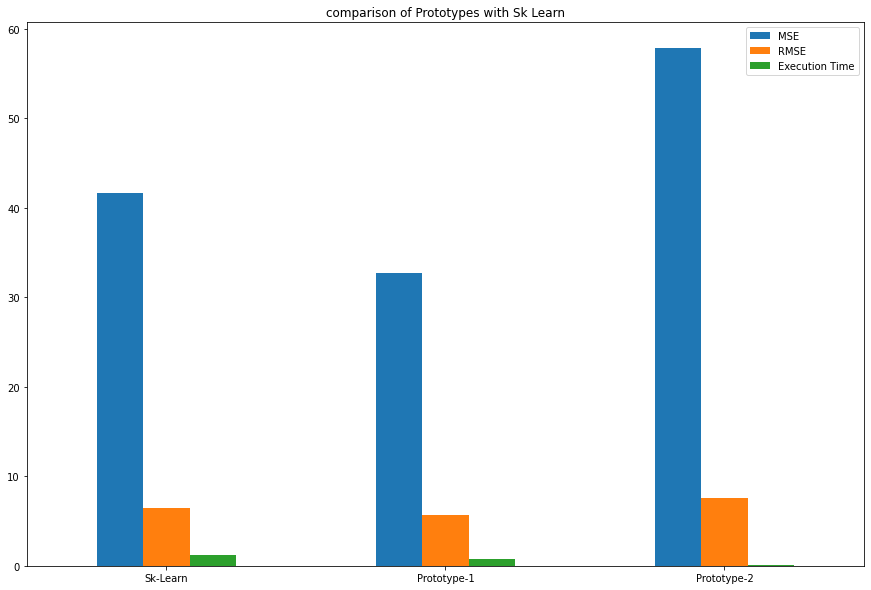

In [41]:
import matplotlib.pyplot as plot
df.plot.bar(figsize=(15,10),rot=0, title="comparison of Prototypes with Sk Learn");
plot.show(block=True);

<AxesSubplot:>

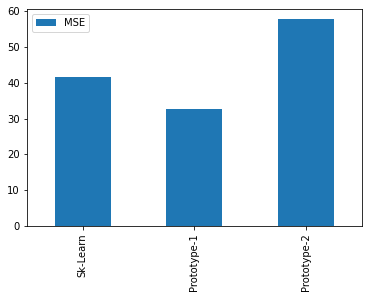

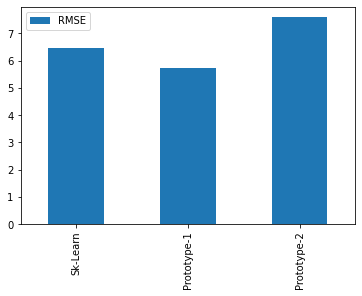

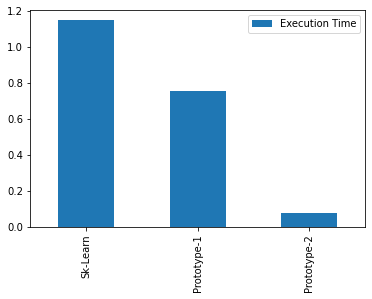

In [42]:
import seaborn as sns
df.plot.bar(y='MSE',use_index=True)
df.plot.bar(y='RMSE',use_index=True)
df.plot.bar(y='Execution Time',use_index=True)

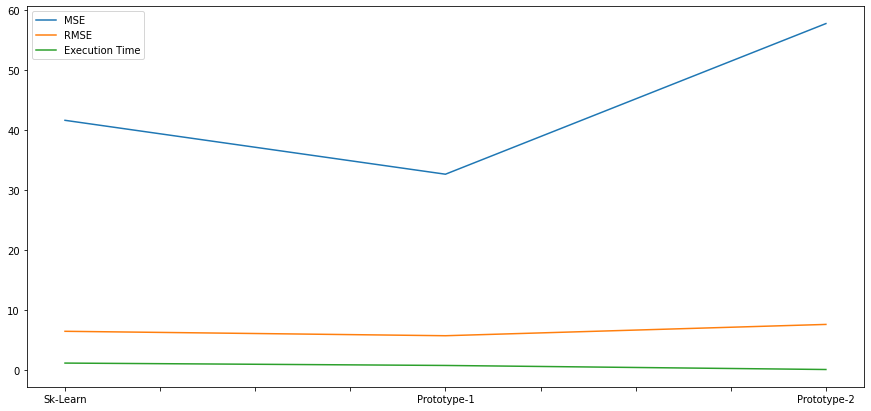

In [43]:
ax = df.plot.line(figsize=(15,7))